# 0: Section Overview

In the final section of our report, we will directly compare the performance of each model on a randomly selected country within the test data and visualize each model's predicted reproduction rate across the time period. We will also assess how each model performed on the entire test dataset, using our chosen performance metric, Mean Squared Error (MSE), to evaluate overall predictive performance. Finally, we will discuss the strengths and limitations of MSE as an evaluation metric and its implications for model reliability in similar predictive tasks.


# 1: Necessary Imports



In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import random
from sklearn.ensemble import RandomForestRegressor

# 2: Data access

As done previously, we need to access the test and training datasets.

In [5]:
test_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\test.xlsx" # Enter your file path for the train data
train_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\train.xlsx" # Enter your file path for the test data

test_data = pd.read_excel(test_filepath)
train_data = pd.read_excel(train_filepath)

# 3: Model Performance Comparison

As previously mentioned, this section of the conclusion will focus on comparing the performance of the models based on our performance metric, Mean Squared Error (MSE). We will evaluate MSE for a randomly selected country within the test dataset as well as for the entire dataset to provide a broader view of each model's accuracy. Additionally, we will perform visualization comparisons, plotting the reproduction rate for the selected country with each model’s predictions overlaid. This way, we can analyze both the quantitative result and how well each models' prediction aligns visually with the actual reproduction rate. Note, each group member has put forward their cross-validated, best model (i.e. the best implimentation of their model and not just the vanilla version).

### Random Test Country Comparison 

- graph
- MSE values
- comparing these results 
- what this means for our model
- talk about the graph and MSE for that country
- Generalising to the whole testing dataset talk about the MSE for the entire model

### Selecting a country 

The following block of code takes all the unique iso_codes from the test data and randomely selects one of them. This iso_code will determine which country from the test data we perform this model comparison on.

In [16]:
random.seed(21) # for replicability
iso_codes = test_data['iso_code'].unique()
random_iso_code = random.choice(iso_codes)
print(random_iso_code)

GBR


Now, we want to train our models in exactly the same way as before but instead of testing the models on the entire testing dataset, we can filter the test results to only include data from our randomely selected country. We also need to perform the standard selecting of covariate columns as we have done in the previous model implimentations

In [87]:
random_country_test_data = test_data[test_data['iso_code'] == random_iso_code]

#### Training data

In [75]:
covariates = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths']
covariates_and_repr = covariates + ['reproduction_rate']
train_data_filtered = train_data[covariates_and_repr]
X_train = train_data_filtered[covariates]
y_train = train_data_filtered['reproduction_rate']
print()
print(X_train.shape)
print(len(y_train))


(134618, 9)
134618


#### Testing data

In [76]:
test_data_filtered = test_data[covariates_and_repr]
X_test = test_data_filtered[covariates]
y_test = test_data_filtered[['reproduction_rate']]
print()
print(X_test.shape)
print(len(y_test))



(32431, 9)
32431


#### Testing data for random country 

We want to access the test data just for the single country aswell.

In [79]:
random_country_X_test = random_country_test_data[covariates]
random_country_Y_test = random_country_test_data['reproduction_rate']



#### Retraining the models with cross-validated hyperparameters

In order to plot the Reproduction rate, we need to train and test each model as in each model section. we will also test each model on solely the GBR data aswell to see how each model performed in this particular country case.

##### Linear Model

In [83]:
linear_model = LinearRegression()
# Fit the model on the training data
linear_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)
print("y_pred shape:", y_pred_linear.shape)
# Calculate Mean Squared Error (MSE) on the test data
mse_linear = mean_squared_error(y_test, y_pred_linear)
R_squared_linear = linear_model.score(X_test, y_test)
print(mse_linear)

y_pred_linear_random_country = linear_model.predict(random_country_X_test)
mse_linear_random_country = mean_squared_error(random_country_Y_test, y_pred_linear_random_country)
R_squared_linear = linear_model.score(random_country_X_test, random_country_Y_test)
print(mse_linear_random_country)


y_pred shape: (32431,)
0.13260849618243836
0.09171188519587926


##### KNN model

Lucy performed multiple implimentations of the KNN model. The model described below his her final submission adjusted through cross-validation.

##### RF model

Similarly, Harry performed multiple implimentations of the RF model. The model initialised below was his final model submission adjusted through cross-validation. Since Harry implimented his section in R, in order to overlay the rf model result onto the graph, we reimplimented the RF model in python. 

In [84]:
rf_model_tuned = RandomForestRegressor(
    n_estimators=350,      # Number of trees
    max_features=2,        # Number of features to consider at each split (equivalent to mtry in R)
    bootstrap=True,        # Sample with replacement
    n_jobs=1,              # Number of parallel jobs to run (-1 to use all processors)
    random_state=42
)

# Fit the model
rf_model_tuned.fit(X_train, y_train)
y_pred_rf = rf_model_tuned.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
R_squared_rf = rf_model_tuned.score(X_test, y_test)
print(mse_rf)

y_pred_rf_random_country = rf_model_tuned.predict(random_country_X_test)
mse_rf_random_country = mean_squared_error(random_country_Y_test, y_pred_rf_random_country)
R_squared_rf = rf_model_tuned.score(random_country_X_test, random_country_Y_test)



0.1142639881372257


##### Stacked model

### Visualising the reproduction rate w/ model predictions

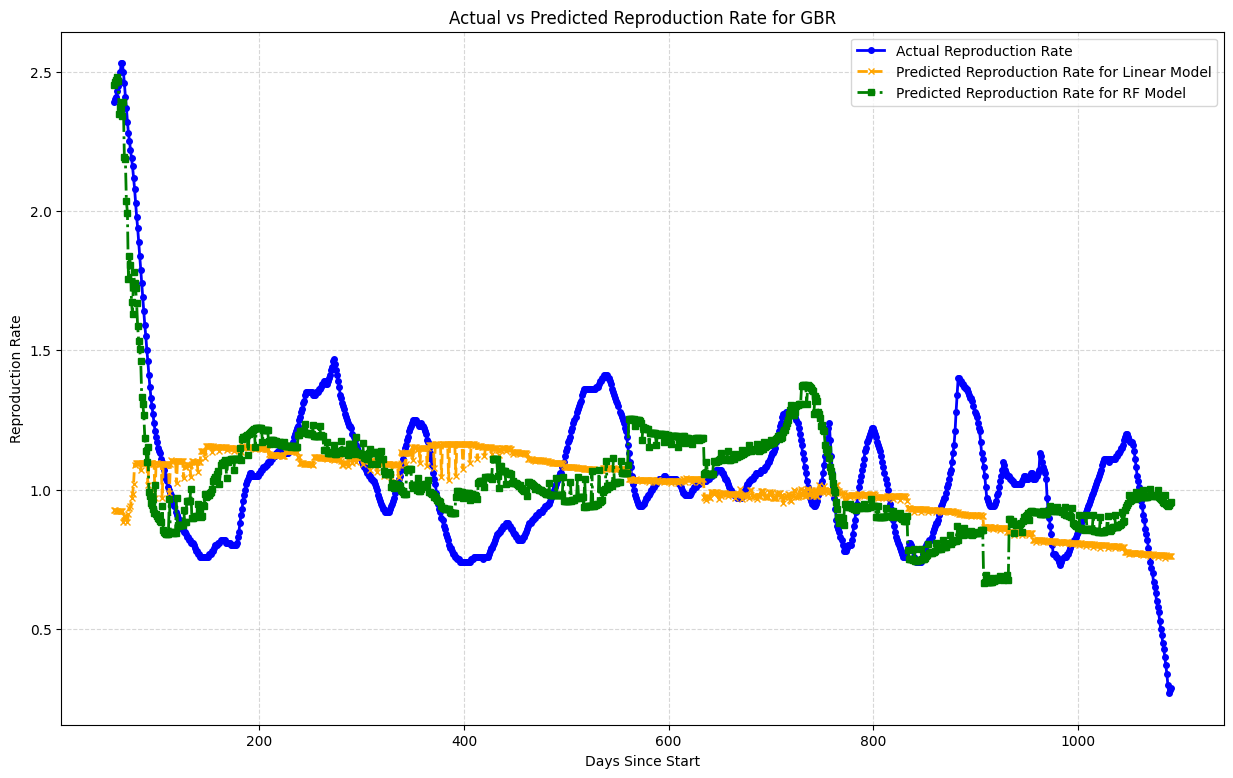

MSE for Linear model using ALL test data:  0.13260849618243836
MSE for Linear model using only GBR test data:  0.09171188519587926

MSE for RF model using ALL test data:  0.1142639881372257
MSE for RF model using only GBR test data:  0.0473269855413887


In [90]:
plt.figure(figsize=(15, 9))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_linear_random_country, 
         label="Predicted Reproduction Rate for Linear Model", color='orange', linestyle='--', marker='x', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_rf_random_country, 
         label="Predicted Reproduction Rate for RF Model", color='green', linestyle='-.', marker='s', markersize=4, linewidth=2)

# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


print('MSE for Linear model using ALL test data: ', mse_linear)
print('MSE for Linear model using only GBR test data: ', mse_linear_random_country)
print()
print('MSE for RF model using ALL test data: ', mse_rf)
print('MSE for RF model using only GBR test data: ', mse_rf_random_country)




# 4: Performance Metric Evaluation

the nature of our problem (one figure vs ROC curve for example)

why MSE might not be the best, why something ASE might be better, anything else

# 5: Limitation Acknowledgement and Final Takeaways

- any kind of things you would have added to your models if you had more time (breif). 


This substitution allows the model to function but does not account for NK-specific factors, meaning predictions should be interpreted cautiously. Future availability of NK data could significantly improve model accuracy and relevance."

- final 'best' model submission and reference to the introduction in a real life environemt. 